<h1>The Political Role of COVID-19</h1>

Group 3: Justin Deutsch, Djustin8; Emily Lawson, emily03; Matthew Pinho, mpinho16

The COVID-19 pandemic has people flooding the internet with updates, facts, and opinions but peoples opinions can differ, change over time, align with their political parties or none of the above creating a lot of confusion. Now is not the time for indecisiveness, debate, and disagreement. The economy, people’s livelihoods, and most importantly people’s lives are at stake. 

Therefore, Group 3 will evaluate, and analyze the growth over time of the political relevance of COVID-19 as well as compare and contrast the sentiments and the perspective of the major political figures on the pandemic of both major political parties.

We want to know how have sentiments changed about the pandemic crisis over time generally and party-wise? How has the vocabulary changed? How different do Democrats and Republicans think? As well as how loyal are their members to their party’s viewpoints?

<h2> Step 1 </h2>

First we gathered all Tweets from 6 political representatives (3 from each party) from the beginning of March up until April 19th.

In [1]:
def appendTweet(data,tweet):
    row = [tweet.user.name,tweet.user.screen_name,tweet.full_text,
           tweet.created_at,tweet.favorite_count,tweet.retweet_count,hasattr(tweet, 'retweeted_status'),
           'media' in tweet.entities]
    row_series = pandas.Series(row, index = data.columns)
    data = data.append(row_series, ignore_index=True)
    return data

def getTweetsSince(since_id,username,data):
    page = 1
    while True:
        tweets = api.user_timeline(id=username,page=page,tweet_mode='extended')
        if tweets and str(tweets[-1].created_at) > since_id:
            for tweet in tweets:
                data = appendTweet(data,tweet)
        else:
            return data
        page += 1

<h3> Step 2 </h3>

Next we filtered the Tweets using a bag of words to find only the ones relevant to the pandemic

## Loading Data

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from itertools import groupby

In [3]:
# Loading in the data from FILE
DATA_FILE = './six_politicians.csv'

In [4]:
# Reading the data 
df = pd.read_csv(DATA_FILE, index_col=0)

# Converting the data Created to a datetime object
df['Created'] = pd.to_datetime(df['Created'])

df.shape, df.dtypes

((2498, 8),
 Name                      object
 Username                  object
 Text                      object
 Created           datetime64[ns]
 Favorite Count             int64
 Retweet Count              int64
 Retweeted                   bool
 Media Attached              bool
 dtype: object)

In [5]:
# Displaying the list of people and their twitter handles
names_handles = zip(df['Name'].unique().tolist(), df['Username'].unique().tolist())

print(f"{'Name':>20} ---> Twitter Handle")
print('----------------------------------------')
for n, h in names_handles:
    print(f'{n:>20} ---> {h}')

                Name ---> Twitter Handle
----------------------------------------
     Donald J. Trump ---> realDonaldTrump
        Ron DeSantis ---> GovRonDeSantis
         Marco Rubio ---> marcorubio
           Joe Biden ---> JoeBiden
        Andrew Cuomo ---> NYGovCuomo
      Bernie Sanders ---> BernieSanders


In [6]:
df.head()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached
0,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-19 22:25:08,0,3060,False,False
1,Donald J. Trump,realDonaldTrump,White House News Conference at 5:45. Thank you!,2020-04-19 20:13:28,62328,12827,False,False
2,Donald J. Trump,realDonaldTrump,Thank you to my boy! https://t.co/GAFe1AdZpt,2020-04-19 19:38:09,70865,25015,False,False
3,Donald J. Trump,realDonaldTrump,“On February 19th there was a Democratic Debat...,2020-04-19 19:18:05,63158,19546,False,False
4,Donald J. Trump,realDonaldTrump,Great book by @SenatorTimScott! https://t.co/9...,2020-04-19 19:15:28,20342,5419,False,False


## Preprocessing

### Removing Keywords

In [7]:
KEYWORD_FILE = './covid_keywords.txt'

In [8]:
# Loading keywords
keywords = []

with open(KEYWORD_FILE, 'r') as f:
    line = f.readline()
    while line:
        keywords.append(line.strip().lower())
        line = f.readline()

len(keywords), keywords[:5]

(61, ['unemployment', 'front line', 'testing', 'health', 'public health'])

In [9]:
# Making keywords regex safe then filtering df by them
safe_keywords = [re.escape(word) for word in keywords]
clean_df = df[df['Text'].str.lower().str.contains('|'.join(safe_keywords))].copy()

df.shape, clean_df.shape

((2498, 8), (1174, 8))

# Analysis

## Summary Statistics

### Count of Covid Tweets

In [10]:
# counts tweets per user
def count_tweets_per_user(df):
    counts = []
    
    for user in df['Username'].unique():
        counts.append((user, df[df['Username'] == user].shape[0]))
    
    return counts

In [11]:
from itertools import groupby

# counting tweets for each user before/after filtering by keywords
num_tweets_before_filtering = count_tweets_per_user(df)
num_tweets_after_filtering = count_tweets_per_user(clean_df)

# joining the two lists together 
num_tweets_before_after = num_tweets_before_filtering + num_tweets_after_filtering

# sorting by username so users' counts are next to each other, needed for groupby
num_tweets_before_after = sorted(num_tweets_before_after)

d = groupby(num_tweets_before_after, lambda x: x[0])
counts = []

for x in d:
    f = next(x[1])[1]
    s = next(x[1])[1]
    counts.append((x[0], max(f, s), min(f, s)))

counts

[('BernieSanders', 558, 250),
 ('GovRonDeSantis', 40, 16),
 ('JoeBiden', 500, 253),
 ('NYGovCuomo', 620, 407),
 ('marcorubio', 480, 161),
 ('realDonaldTrump', 300, 87)]

In [12]:
# Percent tweets that are covid related:
for entry in counts:
    print(f'{entry[0]}: {min(entry[1], entry[2]) / max(entry[1], entry[2]):.2%}')

BernieSanders: 44.80%
GovRonDeSantis: 40.00%
JoeBiden: 50.60%
NYGovCuomo: 65.65%
marcorubio: 33.54%
realDonaldTrump: 29.00%


### Word and Character Counts

In [13]:
clean_df['num_chars'] = clean_df['Text'].map(len)
clean_df['word_count'] = clean_df['Text'].map(lambda x: len(x.split()))     # this isn't robust against not,very,well,written,tweets
                                                                            # should change this to use regular expression or library 

In [14]:
clean_df[['num_chars', 'word_count']].describe()

,num_chars,word_count
count,1174.000000,1174.000000
mean,209.552811,33.672061
std,68.383854,11.937988
min,29.000000,3.000000
25%,144.000000,24.000000
50%,227.000000,36.000000
75%,273.000000,43.750000
max,333.000000,57.000000


## NLTK Sentiment Analysis

Our initial thoughts were that sentiment analysis may yield some results that could help distinguish if people's thoughts regarding COVID-19 changed over time. We have begun looking at general trends present in the sentiment scores of each tweet and done basic visualizations. With these results, we are unsure if the sentiment scores alone may provide the insight into the data that we are interested in. With the graphs presented here, we do not see much variety in the sentiment scores. It appears that the sentiments may be slightly biased towards having compound sentiments.

Potential causes for this may be the VADER sentiment analysis algorithm itself in conjunction with the preprocessing done on the data. Using a bag of words approach, VADER may not be cognizant of many of the terms foudn in these tweets since the topic is so recent; the words may not be present in the bag used. Additionally, the preprocessing could hinder the results. Further work must be done in how we preprocess and clean the text. 

Sentiment analysis may also not show the results that we are looking for. Beyond improving our text cleaning and potentially the bag of words used, we will be exploring methods of using the sentiment scores in conjunction with other data pieces to perform different analyses.

In [15]:
# Installs nltk if you don't have it
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [16]:
# import and download lexicon
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
# Creating the Analyzer
sid = SentimentIntensityAnalyzer()

In [18]:
def sentiment(row):
    sent = sid.polarity_scores(row['Text'])
    row['pos'] = sent['pos']
    row['neg'] = sent['neg']
    row['neu'] = sent['neu']
    row['compound'] = sent['compound']
    return row

clean_df = clean_df.apply(lambda row: sentiment(row), axis=1)

In [19]:
#setting major_score to greater of pos/neg, if negative, multiplying by -1
clean_df['major_score'] = clean_df[['pos', 'neg']].apply(lambda row: row['pos'] if row['pos'] >= row['neg'] else row['neg'] * -1, axis=1)

In [20]:
clean_df.head()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached,num_chars,word_count,pos,neg,neu,compound,major_score
0,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-19 22:25:08,0,3060,False,False,88,10,0.0,0.00,1.00,0.0000,0.00
3,Donald J. Trump,realDonaldTrump,“On February 19th there was a Democratic Debat...,2020-04-19 19:18:05,63158,19546,False,False,147,23,0.0,0.00,1.00,0.0000,0.00
10,Donald J. Trump,realDonaldTrump,RT @RepLeeZeldin: While @realDonaldTrump belie...,2020-04-19 18:11:27,0,5934,False,False,140,20,0.0,0.28,0.72,-0.7906,-0.28
12,Donald J. Trump,realDonaldTrump,RT @kimguilfoyle: “In responding to the outbre...,2020-04-19 18:08:54,0,3917,False,False,140,20,0.0,0.00,1.00,0.0000,0.00
16,Donald J. Trump,realDonaldTrump,RT @DonaldJTrumpJr: Germany’s largest newspape...,2020-04-19 17:34:39,0,18608,False,False,140,22,0.0,0.00,1.00,0.0000,0.00


# Vizualizing Data

In [21]:
user_groups = clean_df.groupby('Username')

In [22]:
user_groups.groups.keys()

dict_keys(['BernieSanders', 'GovRonDeSantis', 'JoeBiden', 'NYGovCuomo', 'marcorubio', 'realDonaldTrump'])

In [174]:
def graph_sentiment(group, ax, key, ylims=(0, 1), title=None):
    ax.set_title(title)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) 
    
    ax.set_ylim(ylims)
    
    ax.plot(group[1]['Created'], group[1][key])

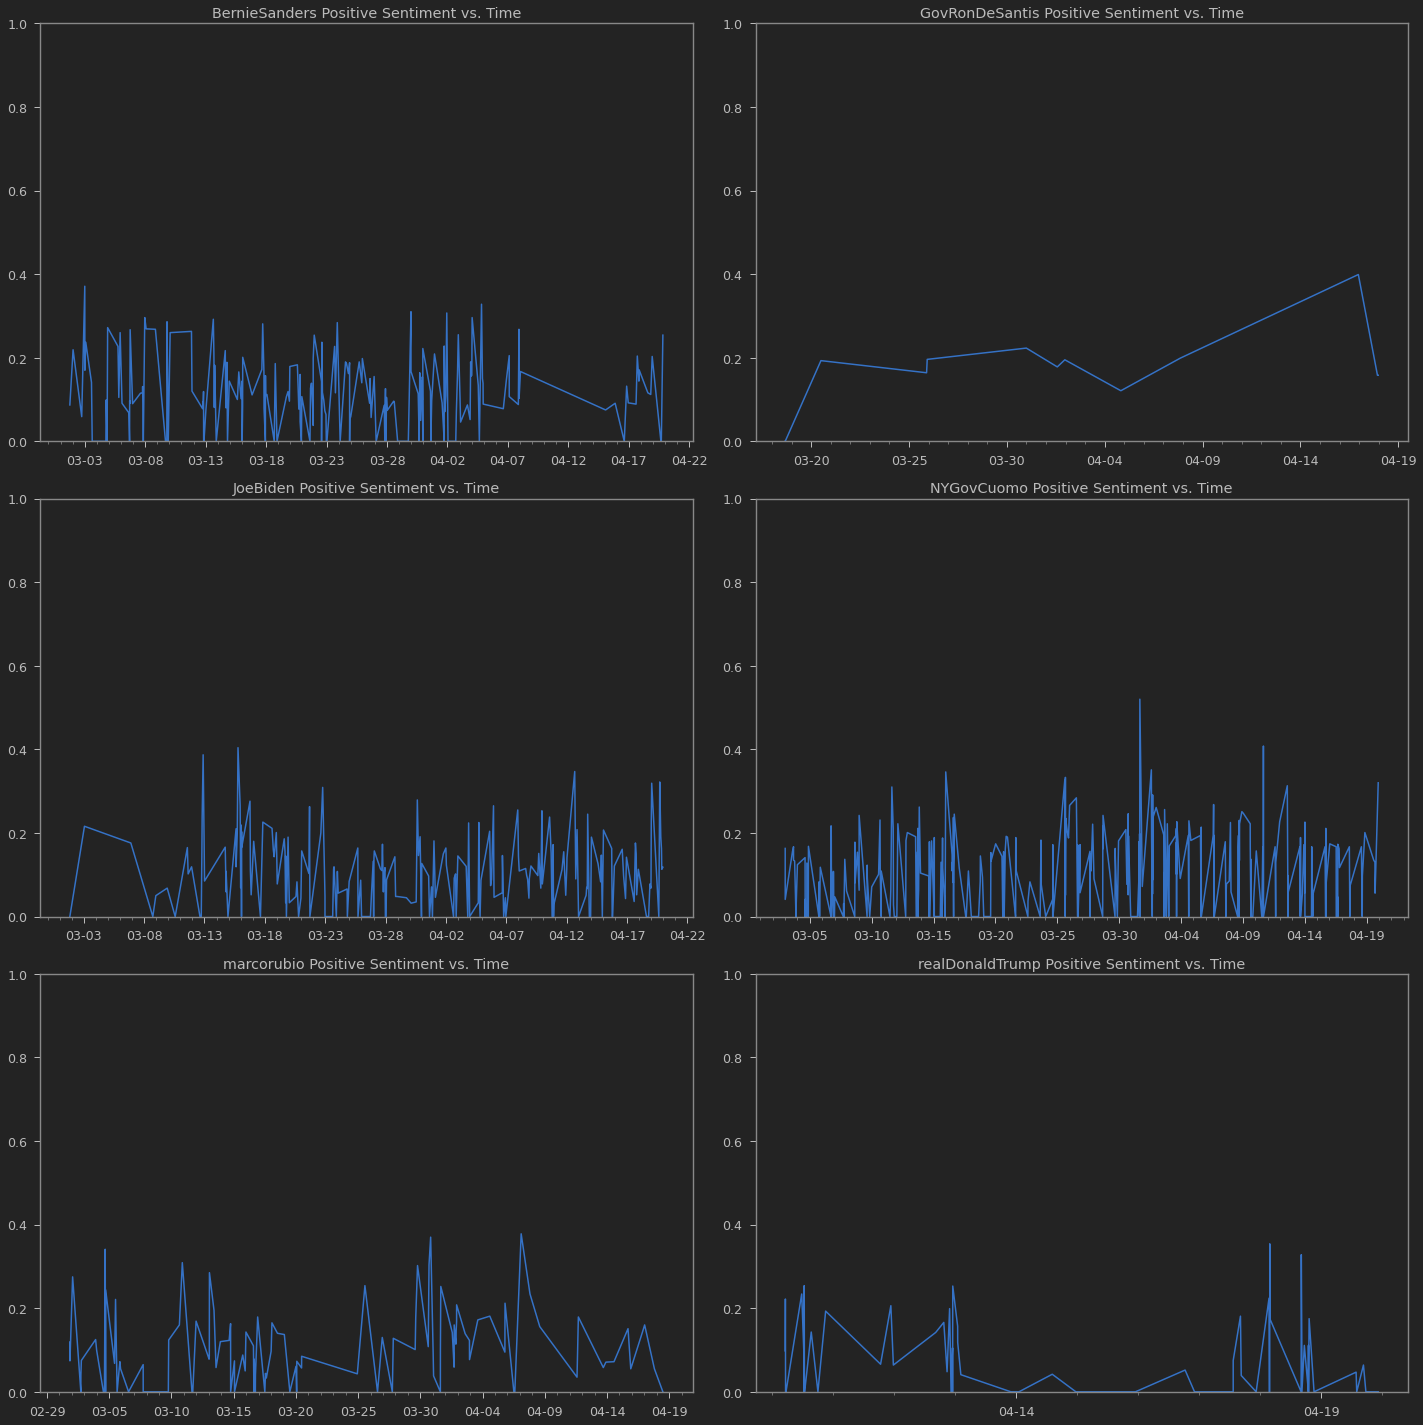

In [177]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

axes = axes.flatten()

for g, ax in zip(user_groups, axes):
    title = f'{g[0]} Positive Sentiment vs. Time'
    graph_sentiment(g, ax, 'pos', title=title)
    
fig.tight_layout()
fig.show()

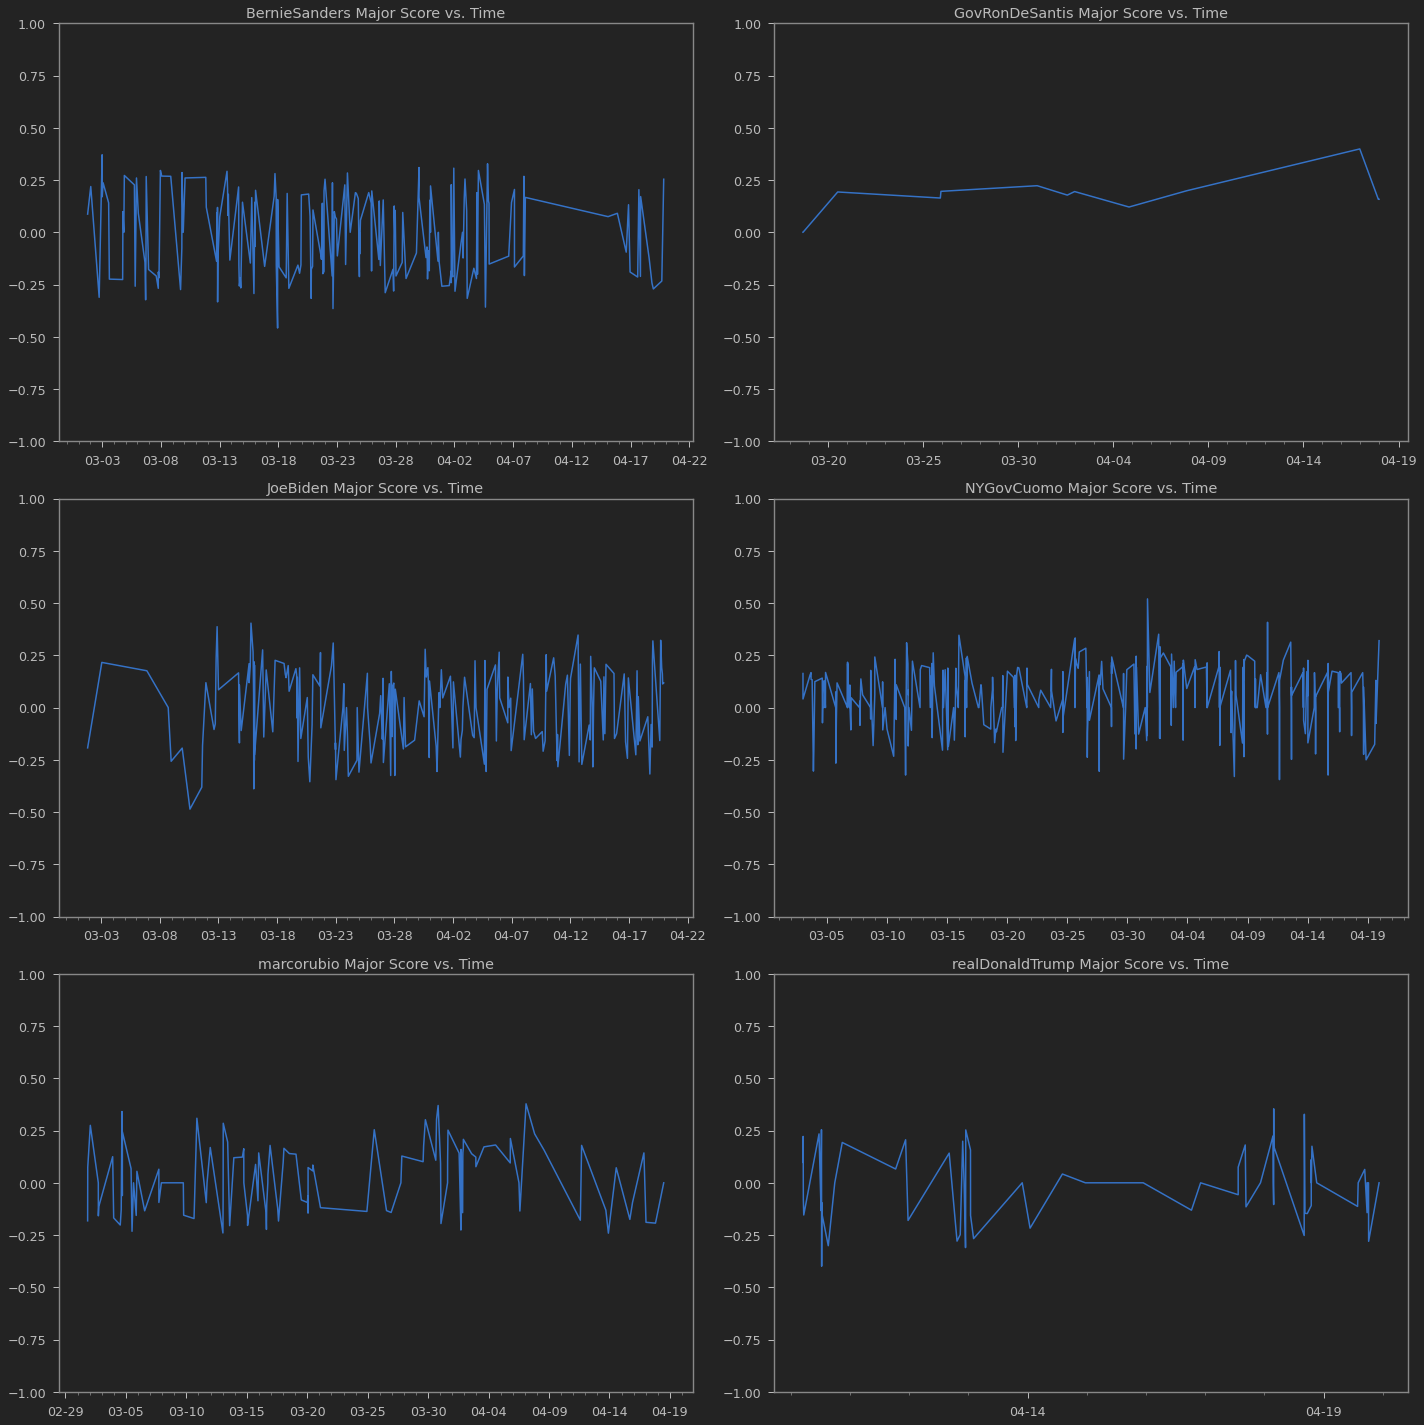

In [178]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

axes = axes.flatten()

for g, ax in zip(user_groups, axes):
    title = f'{g[0]} Major Score vs. Time'
    graph_sentiment(g, ax, 'major_score', ylims=(-1, 1), title=title)
    
fig.tight_layout()
fig.show()

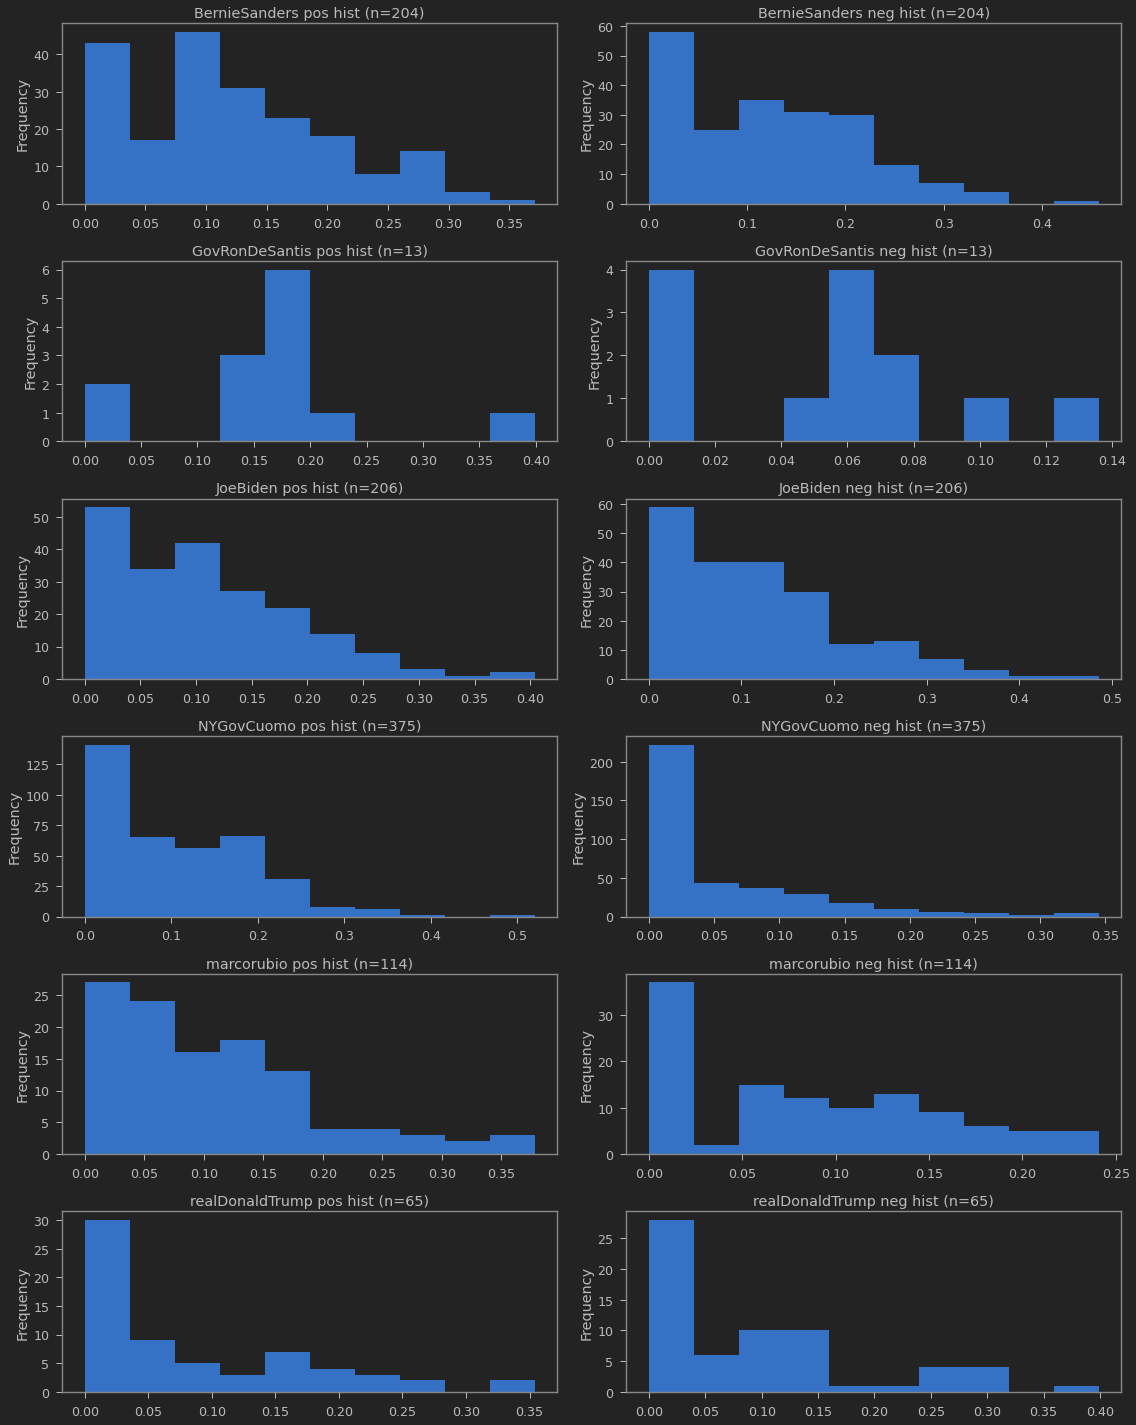

In [192]:
fig, axes = plt.subplots(6, 2, figsize=(16, 20))


for g, ax in zip(user_groups, axes):
    ax[0].set_title(f'{g[0]} pos hist (n={g[1]["pos"].shape[0]})')
    g[1]['pos'].plot(kind='hist', ax=ax[0])
    ax[1].set_title(f'{g[0]} neg hist (n={g[1]["neg"].shape[0]})')
    g[1]['neg'].plot(kind='hist', ax=ax[1])
    
plt.tight_layout()    